In [1]:
import os
import torch
import torch.nn as nn
from torch import optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.svm import SVR
import xgboost as xgb

from energy_function import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


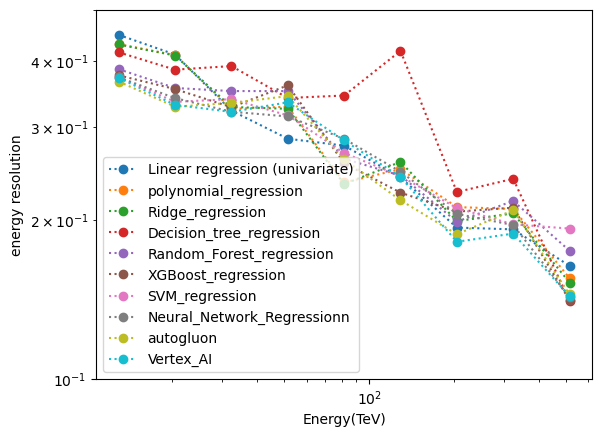

In [2]:
draw_precision()

In [3]:
test_size = 0.4


In [4]:
data = np.load("/home2/hky/github/Gamma_Energy/MCdata/CrabMCData.npz")
Exptdata = np.load(
    "/home2/hky/github/Gamma_Energy/Exptdata/RaDecOffmergedData.npz")
Exptnecut = np.where((Exptdata["ne"]>1e4)&(Exptdata["sigma"]<0.5))
Exptdata = {key: Exptdata[key] for key in Exptdata.keys()}
Exptdata["sectheta"] = 1/np.cos(np.deg2rad(Exptdata["theta"]))

In [5]:
nch = data["nch"]
theta = data["theta"]
phi = data["phi"]
sigma = data["sigma"]
cx = data["cx"]
cy = data["cy"]
sumpf = data["sumpf"]
summd = data["summd"]
mr1 = data["mr1"]
ne = data["ne"]
age = data["age"]
pritheta = data["pritheta"]
priphi = data["priphi"]
prie = data["prie"]
inout = data["inout"]
S50 = data["S50"]


In [6]:
cuted = np.where((theta < 40) & (nch >= 16) & (inout == 1) & (np.log10(
    S50) > -1.2) & (age > 0.31) & (age < 1.3) & ((summd < 2.1e-3*sumpf**1.2) | (summd < 0.4))&(sigma<0.5)&(ne>1e4))


/tmp/ipykernel_1590222/1220625991.py:1: RuntimeWarning: divide by zero encountered in log10
  cuted = np.where((theta < 40) & (nch >= 16) & (inout == 1) & (np.log10(


In [7]:
nch = nch[cuted]
theta = theta[cuted]
phi = phi[cuted]
sigma = sigma[cuted]
cx = cx[cuted]
cy = cy[cuted]
sumpf = sumpf[cuted]
summd = summd[cuted]
mr1 = mr1[cuted]
ne = ne[cuted]
age = age[cuted]
pritheta = pritheta[cuted]
priphi = priphi[cuted]
prie = prie[cuted]/1000
inout = inout[cuted]
S50 = S50[cuted]
sectheta = 1/np.cos(np.deg2rad(theta))

In [8]:
train_index, test_index = train_test_split(
    range(nch.shape[0]), test_size=test_size, shuffle=True, random_state=42)


In [9]:
nch_train = nch[train_index]
theta_train = theta[train_index]
phi_train = phi[train_index]
sigma_train = sigma[train_index]
cx_train = cx[train_index]
cy_train = cy[train_index]
sumpf_train = sumpf[train_index]
summd_train = summd[train_index]
mr1_train = mr1[train_index]
ne_train = ne[train_index]
age_train = age[train_index]
pritheta_train = pritheta[train_index]
priphi_train = priphi[train_index]
prie_train = prie[train_index]
inout_train = inout[train_index]
S50_train = S50[train_index]
sectheta_train = sectheta[train_index]

nch_test = nch[test_index]
theta_test = theta[test_index]
phi_test = phi[test_index]
sigma_test = sigma[test_index]
cx_test = cx[test_index]
cy_test = cy[test_index]
sumpf_test = sumpf[test_index]
summd_test = summd[test_index]
mr1_test = mr1[test_index]
ne_test = ne[test_index]
age_test = age[test_index]
pritheta_test = pritheta[test_index]
priphi_test = priphi[test_index]
prie_test = prie[test_index]
inout_test = inout[test_index]
S50_test = S50[test_index]
sectheta_test = sectheta[test_index]


In [14]:
savepath = "./fig/energy_reconstruction/"


In [ ]:
np.min(np.log10(prie_train)),np.max(prie_train)

(0.2897911115727675, 819.446)

In [10]:
weight_bin = np.logspace(0.2, 3, 29)
weight_train = np.zeros(weight_bin.shape[0]-1)
for i in range(weight_train.shape[0]):
    weight_train[i] = np.sum((prie_train > weight_bin[i])
                           & (prie_train < weight_bin[i+1]))


In [11]:
weight = np.zeros(prie_train.shape)
for i in range(weight_train.shape[0]):
    weight[np.where((prie_train > weight_bin[i])
                           & (prie_train < weight_bin[i+1]))] = weight_train[-1]/weight_train[i]
weight[np.where(prie_train<5)]=np.min(weight)
weight[np.where(prie_train>30)]*=4

In [12]:
train_dict = {"nch": nch_train, "sectheta": sectheta_train, "S50": S50_train, "cx": cx_train, "cy": cy_train,
              "ne": ne_train, "age": age_train, "sumpf": sumpf_train, "summd": summd_train,"mr1":mr1_train, "energy": prie_train, "log_energy": np.log10(prie_train),"weight":weight}
pd_data = pd.DataFrame(train_dict)
pd_data.to_csv("MC_train_Data.csv",index=False)

test_dict = {"nch": nch_test, "sectheta": sectheta_test, "S50": S50_test, "cx": cx_test, "cy": cy_test,
              "ne": ne_test, "age": age_test, "sumpf": sumpf_test, "summd": summd_test,"mr1":mr1_test, "energy": prie_test, "log_energy": np.log10(prie_test)}
pd_data = pd.DataFrame(test_dict)
pd_data.to_csv("MC_test_Data.csv",index=False)

Expt_dict = {"nch": Exptdata["nch"], "sectheta": Exptdata["sectheta"], "S50": Exptdata["S50"], "cx": Exptdata["cx"], "cy": Exptdata["cy"],
              "ne": Exptdata["ne"], "age": Exptdata["age"], "sumpf": Exptdata["sumpf"], "summd": Exptdata["summd"],"mr1":Exptdata["mr1"]}
pd_data = pd.DataFrame(Expt_dict)
pd_data.to_csv("Expt_Data.csv",index=False)

# 线性回归

Epoch 1000, loss: 0.0241
Epoch 2000, loss: 0.0208
Epoch 3000, loss: 0.0208
Epoch 4000, loss: 0.0208
Epoch 5000, loss: 0.0208
Epoch 6000, loss: 0.0208


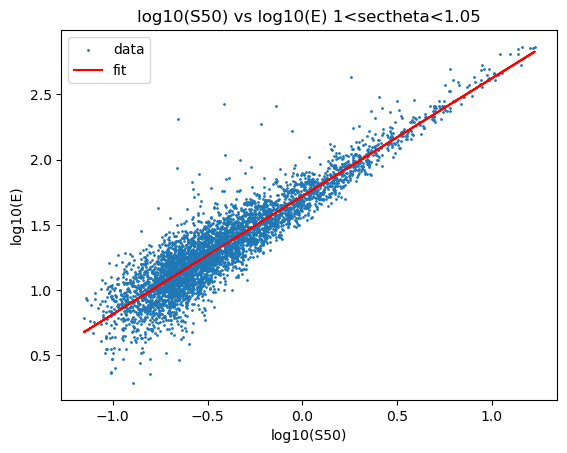

Epoch 1000, loss: 0.0243
Epoch 2000, loss: 0.0228
Epoch 3000, loss: 0.0228
Epoch 4000, loss: 0.0228
Epoch 5000, loss: 0.0228
Epoch 6000, loss: 0.0228


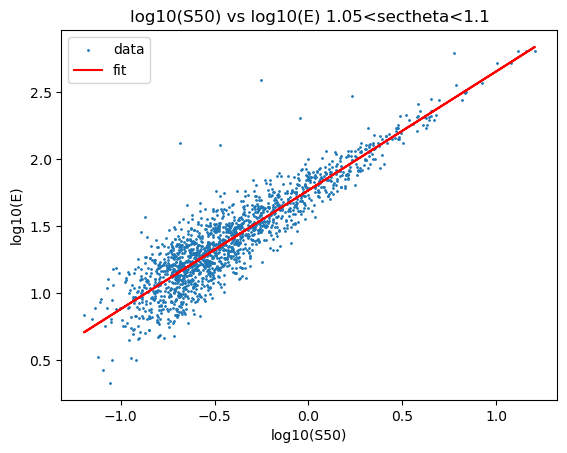

Epoch 1000, loss: 0.0348
Epoch 2000, loss: 0.0335
Epoch 3000, loss: 0.0335
Epoch 4000, loss: 0.0335
Epoch 5000, loss: 0.0335
Epoch 6000, loss: 0.0335


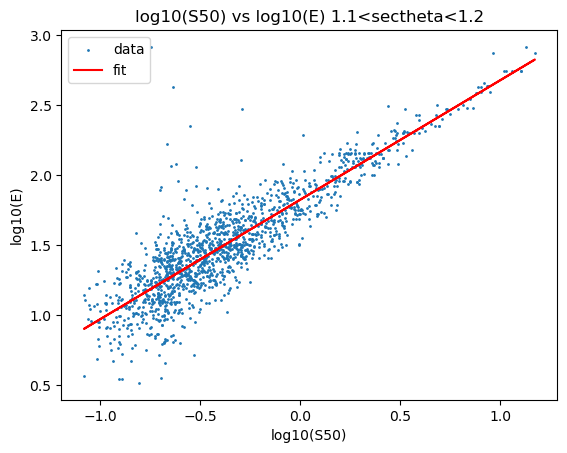

Epoch 1000, loss: 0.0411
Epoch 2000, loss: 0.0395
Epoch 3000, loss: 0.0395
Epoch 4000, loss: 0.0395
Epoch 5000, loss: 0.0395
Epoch 6000, loss: 0.0395


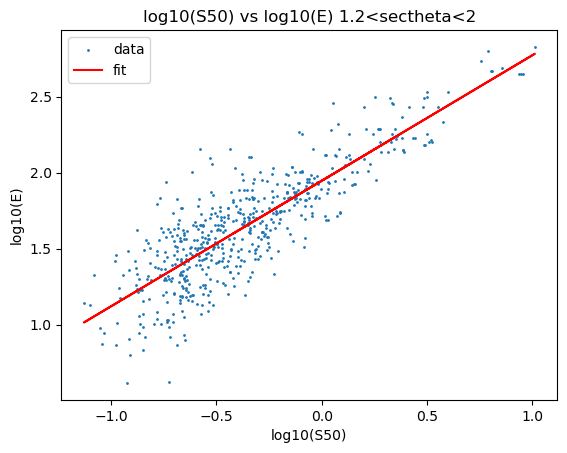

In [22]:
sectheta_min = [1, 1.05, 1.1, 1.2]
sectheta_max = [1.05, 1.1, 1.2, 2]
energy_pred = np.zeros(prie_test.shape).reshape(-1, 1)
energy_orgin = prie_test.reshape(-1, 1)
Linear_model_list = list()
method = "linear_regression"
tmpsavepath = os.path.join(savepath, method)

for i in range(4):
    tmpcut = np.where((sectheta_train > sectheta_min[i]) & (
        sectheta_train < sectheta_max[i]))

    # 导入特征
    x = np.log10(S50_train[tmpcut])
    y = np.log10(prie_train[tmpcut])

    # 转换为 tensor
    x = torch.from_numpy(x.reshape(-1, 1)).float()
    y = torch.from_numpy(y.reshape(-1, 1)).float()

    # 定义模型
    model = torch.nn.Linear(1, 1)

    # 定义损失函数
    loss_fn = torch.nn.MSELoss()

    # 定义优化器
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# 训练模型
    num_epochs = 6000  # 迭代次数
    for epoch in range(num_epochs):
        # 前向传播
        y_pred = model(x)
        # 计算损失
        loss = loss_fn(y_pred, y)
        # 反向传播和更新参数
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 打印信息
        if (epoch + 1) % 1000 == 0:
            print(f"Epoch {epoch+1}, loss: {loss.item():.4f}")
    Linear_model_list.append(model)
    plt.scatter(x.numpy(), y.detach().numpy(), label="data", s=1)
    plt.plot(x.numpy(), y_pred.detach().numpy(), color="red", label="fit")
    plt.xlabel("log10(S50)")
    plt.ylabel("log10(E)")
    plt.title("log10(S50) vs log10(E) " +
              f"{sectheta_min[i]}<sectheta<{sectheta_max[i]}")
    plt.legend()
    mkdir(tmpsavepath)
    plt.savefig(
        f"{tmpsavepath}/S50_E_{sectheta_min[i]}<sectheta<{sectheta_max[i]}.png")
    plt.show()

    tmpcut_test = np.where((sectheta_test > sectheta_min[i]) & (
        sectheta_test < sectheta_max[i]))
    x_test = np.log10(S50_test[tmpcut_test])
    y_test = np.log10(prie_test[tmpcut_test])
    x_test = torch.from_numpy(x_test.reshape(-1, 1)).float()
    y_test = torch.from_numpy(y_test.reshape(-1, 1)).float()

    y_pred = model(x_test)
    energy_pred[tmpcut_test] = y_pred.detach().numpy()

# energy_orgin = 10**energy_orgin
energy_pred = 10**energy_pred


<Figure size 640x480 with 0 Axes>

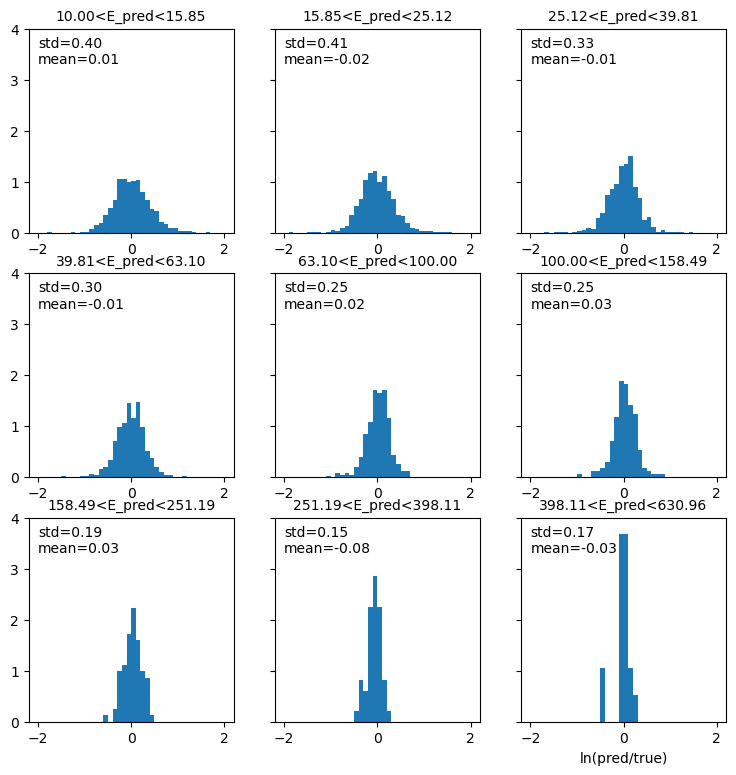

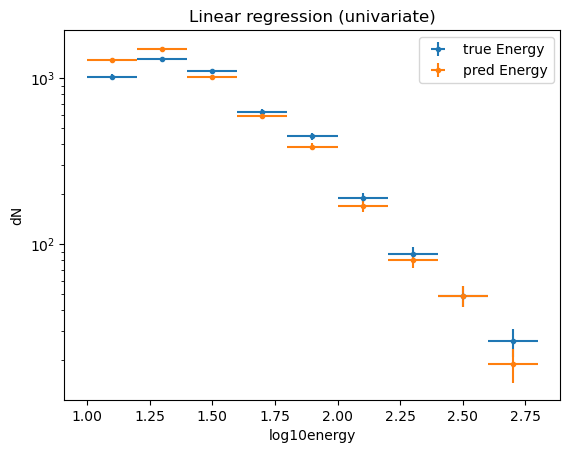

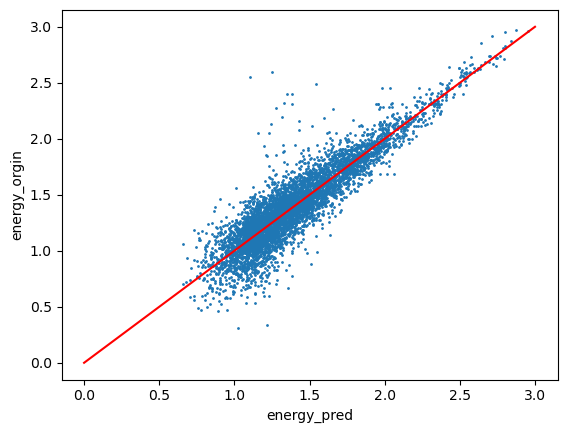

In [23]:
check_fit(energy_pred, energy_orgin,
          "Linear regression (univariate)", tmpsavepath)


In [24]:
ExptEnergy = np.zeros(Exptdata["theta"].shape)
for i in range(4):
    tmpcut = np.where((Exptdata["sectheta"] > sectheta_min[i]) & (
        Exptdata["sectheta"] < sectheta_max[i]))
    model = Linear_model_list[i]
    x = np.log10(Exptdata["S50"][tmpcut])
    x = torch.from_numpy(x.reshape(-1, 1)).float()
    ExptEnergy[tmpcut] = 10**(model(x).detach().numpy()
                              .reshape(ExptEnergy[tmpcut].shape))


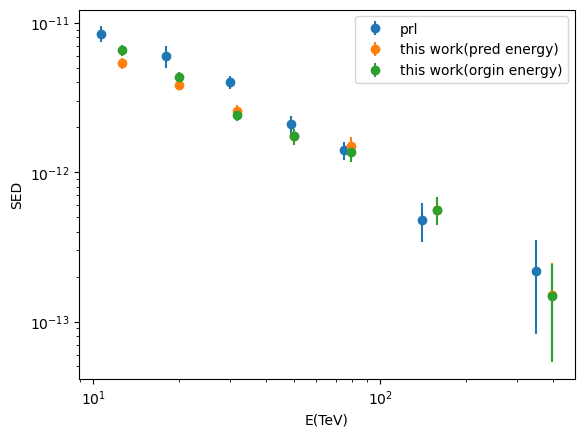

+--------------+--------------+--------+----------+--------+-------------+-----------------+--------------+------------------+
|   Energy min |   Energy max |     On |      Off |   Over |   rate_pred |   Spectrum_pred |   rate_orgin |   Spectrum_orgin |
+==============+==============+========+==========+========+=============+=================+==============+==================+
|         1.00 |         1.20 | 685.00 | 10590.49 | 155.48 |      0.0182 |      5.3850e-12 |       0.0149 |       6.5703e-12 |
+--------------+--------------+--------+----------+--------+-------------+-----------------+--------------+------------------+
|         1.20 |         1.40 | 476.00 |  5947.95 | 178.60 |      0.0465 |      3.8291e-12 |       0.0411 |       4.3413e-12 |
+--------------+--------------+--------+----------+--------+-------------+-----------------+--------------+------------------+
|         1.40 |         1.60 | 228.00 |  2259.20 | 115.04 |      0.0702 |      2.5907e-12 |       0.0751 |    

In [25]:
GetSpectrum(Exptdata, ExptEnergy, energy_pred, energy_orgin, sectheta_test, sumpf_test,
            theta_test, phi_test, pritheta_test, priphi_test, test_size, tmpsavepath)


# 多项式回归

In [ ]:
method = "polynomial_regression"
tmpsavepath = os.path.join(savepath, method)
mkdir(tmpsavepath)
for degree in range(1, 10):
    x = np.array([np.log10(S50_train), sectheta_train]).T
    y = np.log10(prie_train)
    # 创建多项式特征生成器
    poly = PolynomialFeatures(degree=degree)

    # 转换特征
    X = poly.fit_transform(x)

    # 创建线性回归模型
    model = LinearRegression()

    # 进行3则交叉验证，指定评分标准为R^2，并返回数组形式的分数
    scores = cross_val_score(
        model, X, y, cv=5, scoring='neg_mean_squared_error')

    # 计算交叉验证的平均分数和标准差
    mean_score = scores.mean()
    std_score = scores.std()
    print(degree, mean_score, std_score)


In [ ]:
degree = 5
x = np.array([np.log10(S50_train), sectheta_train]).T
y = np.log10(prie_train)
# 创建多项式特征生成器
poly = PolynomialFeatures(degree=degree)

# 转换特征
X = poly.fit_transform(x)

# 创建线性回归模型
model = LinearRegression()

model.fit(X, y)

x_test = np.array([np.log10(S50_test), sectheta_test]).T
X_test = poly.fit_transform(x_test)

energy_pred = 10**model.predict(X_test)
energy_orgin = prie_test


In [ ]:
check_fit(energy_pred, energy_orgin, method, tmpsavepath)


In [ ]:
Expt_x = np.array([np.log10(Exptdata["S50"]), Exptdata["sectheta"]]).T
Expt_X = poly.fit_transform(Expt_x)

ExptEnergy = 10**model.predict(Expt_X)
GetSpectrum(Exptdata, ExptEnergy, energy_pred, sectheta_test, sumpf_test,
            theta_test, phi_test, pritheta_test, priphi_test, test_size, tmpsavepath)


In [ ]:
draw_precision()


In [ ]:
method = "Ridge_regression"
tmpsavepath = os.path.join(savepath, method)
mkdir(tmpsavepath)
scoremax = -2
for degree in range(1, 10):
    for alpha in np.linspace(0, 0.2, 41):
        x = np.array([np.log10(S50_train), sectheta_train]).T
        y = np.log10(prie_train)
        # 创建多项式特征生成器
        poly = PolynomialFeatures(degree=degree)

        # 转换特征
        X = poly.fit_transform(x)

        # 创建线性回归模型
        ridge = Ridge(alpha=alpha)

        # 进行3则交叉验证，指定评分标准为R^2，并返回数组形式的分数
        scores = cross_val_score(
            ridge, X, y, cv=5, scoring='neg_mean_squared_error')

        # 计算交叉验证的平均分数和标准差
        mean_score = scores.mean()
        std_score = scores.std()
        if scoremax < mean_score:
            scoremax = mean_score
            best_degree = degree
            best_alpha = alpha
        # print(degree,f"{alpha:.1f}", mean_score, std_score)
print(scoremax, best_degree, best_alpha)


In [ ]:
x = np.array([np.log10(S50_train), sectheta_train]).T
y = np.log10(prie_train)
# 创建多项式特征生成器
poly = PolynomialFeatures(degree=best_degree)

# 转换特征
X = poly.fit_transform(x)

# 创建线性回归模型
ridge = Ridge(alpha=best_alpha)

ridge.fit(X, y)

x_test = np.array([np.log10(S50_test), sectheta_test]).T
X_test = poly.fit_transform(x_test)

energy_pred = 10**ridge.predict(X_test)
energy_orgin = prie_test

check_fit(energy_pred, energy_orgin, method, tmpsavepath)


Expt_x = np.array([np.log10(Exptdata["S50"]), Exptdata["sectheta"]]).T
Expt_X = poly.fit_transform(Expt_x)

ExptEnergy = 10**ridge.predict(Expt_X)
GetSpectrum(Exptdata, ExptEnergy, energy_pred, sectheta_test, sumpf_test,
            theta_test, phi_test, pritheta_test, priphi_test, test_size, tmpsavepath)


In [ ]:
draw_precision()
np.save("precision.npy", precision)


# 决策树

In [ ]:
method = "Decision_tree_regression"
tmpsavepath = os.path.join(savepath, method)
mkdir(tmpsavepath)
scoremax = -2
sc = PowerTransformer()
x = np.array([
    S50_train,
    sectheta_train,
    nch_train,
    sumpf_train,
    summd_train,
    mr1_train,
    ne_train,
    age_train,
    # cx_train,
    # cy_train
]).T
y = np.log10(prie_train)

X = sc.fit_transform(x)
for maxdepth in range(2, 10):

    # 创建多项式特征生成器
    # poly = PolynomialFeatures(degree=degree)

    # 转换特征
    # X = poly.fit_transform(x)

    # 创建线性回归模型
    regr = DecisionTreeRegressor(max_depth=maxdepth)

    # 进行3则交叉验证，指定评分标准为R^2，并返回数组形式的分数
    scores = cross_val_score(
        regr, X, y, cv=5, scoring='neg_mean_squared_error')

    # 计算交叉验证的平均分数和标准差
    mean_score = scores.mean()
    std_score = scores.std()
    if scoremax < mean_score:
        scoremax = mean_score
        bestmaxdepth = maxdepth
    print(maxdepth, mean_score, std_score)
print(scoremax, bestmaxdepth)


In [ ]:
x_test = np.array([S50_test, sectheta_test, nch_test,
                  sumpf_test, summd_test, mr1_test, ne_test, age_test]).T
X_test = sc.transform(x_test)

# 创建线性回归模型
regr = DecisionTreeRegressor(max_depth=bestmaxdepth)

regr.fit(X, y)


energy_pred = 10**regr.predict(X_test)
energy_orgin = prie_test

check_fit(energy_pred, energy_orgin, method, tmpsavepath)


Expt_x = np.array([Exptdata["S50"], Exptdata["sectheta"], Exptdata["nch"], Exptdata["sumpf"],
                  Exptdata["summd"], Exptdata["mr1"], Exptdata["ne"], Exptdata["age"]]).T
Expt_X = sc.transform(Expt_x)

ExptEnergy = 10**regr.predict(Expt_X)
GetSpectrum(Exptdata, ExptEnergy, energy_pred, sectheta_test, sumpf_test,
            theta_test, phi_test, pritheta_test, priphi_test, test_size, tmpsavepath)


In [ ]:
draw_precision()
np.save("precision.npy", precision)


# 随机森林

In [ ]:
method = "Random_Forest_regression"
tmpsavepath = os.path.join(savepath, method)
mkdir(tmpsavepath)
scoremax = -2
sc = PowerTransformer()
x = np.array([
    S50_train,
    sectheta_train,
    nch_train,
    sumpf_train,
    summd_train,
    mr1_train,
    ne_train,
    age_train,
    cx_train,
    cy_train
]).T
y = np.log10(prie_train)

X = sc.fit_transform(x)
for treenumber in range(70, 160, 10):

    # 创建多项式特征生成器
    # poly = PolynomialFeatures(degree=degree)

    # 转换特征
    # X = poly.fit_transform(x)

    # 创建线性回归模型
    reg = RandomForestRegressor(n_estimators=treenumber)

    # 进行3则交叉验证，指定评分标准为R^2，并返回数组形式的分数
    scores = cross_val_score(
        reg, X, y, cv=5, scoring='neg_mean_squared_error')

    # 计算交叉验证的平均分数和标准差
    mean_score = scores.mean()
    std_score = scores.std()
    if scoremax < mean_score:
        scoremax = mean_score
        besttreenumber = treenumber
    print(treenumber, mean_score, std_score)
print(scoremax, besttreenumber)


In [ ]:
x_test = np.array([S50_test, sectheta_test, nch_test, sumpf_test,
                  summd_test, mr1_test, ne_test, age_test, cx_test, cy_test]).T
X_test = sc.transform(x_test)

# 创建线性回归模型
reg = RandomForestRegressor(n_estimators=besttreenumber)

reg.fit(X, y)


energy_pred = 10**reg.predict(X_test)
energy_orgin = prie_test

check_fit(energy_pred, energy_orgin, method, tmpsavepath)


Expt_x = np.array([Exptdata["S50"], Exptdata["sectheta"], Exptdata["nch"], Exptdata["sumpf"],
                  Exptdata["summd"], Exptdata["mr1"], Exptdata["ne"], Exptdata["age"], Exptdata["cx"], Exptdata["cy"]]).T
Expt_X = sc.transform(Expt_x)
plt.hist(reg.predict(Expt_X))

# ExptEnergy = 10**reg.predict(Expt_X)
# GetSpectrum(Exptdata, ExptEnergy, energy_pred, sectheta_test, sumpf_test,
#             theta_test, phi_test, pritheta_test, priphi_test, test_size, tmpsavepath)


In [ ]:
plt.hist(reg.predict(Expt_X),bins=40)


In [ ]:
draw_precision()
np.save("precision.npy", precision)


# 神经网络

In [ ]:
weight = torch.from_numpy(weight.reshape(-1,1)).float().to(device)

In [ ]:
method = "Neural_Network_Regressionn"
tmpsavepath = os.path.join(savepath, method)
mkdir(tmpsavepath)


class NNmodel(torch.nn.Module):
    def __init__(self, n_in, n_hidden, n_layer, p_dropout):
        super(NNmodel, self).__init__()
        self.layers = []
        for i in range(n_layer):
            # n_in input neurons connected to i number of output neurons
            self.layers.append(nn.Linear(n_in, n_hidden))
            # Apply activation function - ReLU
            self.layers.append(nn.ReLU(inplace=True))
            self.layers.append(nn.BatchNorm1d(n_hidden))  # Apply batch normalization
            # Apply dropout to prevent overfitting
            self.layers.append(nn.Dropout(p_dropout))
            n_in = n_hidden  # Reassign number of input neurons as the number of neurons from previous last layer

            # Establish the FCC between the last hidden layer and output layer
        self.layers.append(nn.Linear(n_hidden, 1))
        self.layers = nn.Sequential(*self.layers)

    def forward(self, input):
        return self.layers(input)

def weighted_mse_loss(input, target, weight):
    # print(input.shape,target.shape,weight.shape)
    return torch.sum(weight * (input - target) ** 2)


In [ ]:
sc = PowerTransformer()
x = np.array([
    S50_train,
    sectheta_train,
    nch_train,
    sumpf_train,
    summd_train,
    mr1_train,
    ne_train,
    age_train,
    cx_train,
    cy_train
]).T
y = torch.from_numpy(np.log10(prie_train).reshape(-1, 1)).float()

X = torch.from_numpy(sc.fit_transform(x)).float()

loss_function = weighted_mse_loss
loss_test = nn.MSELoss()

In [ ]:
epochs = 2000
kf = KFold(n_splits=5, shuffle=True)
mean_loss_list = []
minloss = 1
for n_hidden in [128, 256, 512]:
    for n_layer in [2, 5, 10, 15, 30, 60]:
        for p_dropout in [0.1, 0.3, 0.5, 0.7, 0.9]:
            loss_list = []
            for train_index, val_index in kf.split(X):
                net = NNmodel(10, n_hidden, n_layer, p_dropout).to(device)
                optimizer = optim.Adam(net.parameters(), lr=0.01)
                net.train()
                for epoch in range(epochs):
                    weight_train = weight[train_index]
                    train_input = X[train_index].to(device)
                    train_y = y[train_index].to(device)
                    outputs = net(train_input)
                    optimizer.zero_grad()
                    loss = loss_function(outputs, train_y, weight=weight_train)
                    loss.backward()
                    optimizer.step()
                net.eval()
                with torch.no_grad():
                    val_input = X[val_index].to(device)
                    val_y = y[val_index].to(device)
                    val_outputs = net(val_input)
                    val_loss = loss_test(val_outputs, val_y)
                    loss_list.append(val_loss.cpu().detach().numpy())
            mean_loss_list.append(np.mean(loss_list))
            print(n_hidden, n_layer, p_dropout, np.mean(loss_list))
            if minloss > np.mean(loss_list):
                minloss = np.mean(loss_list)
                best_n_hidden = n_hidden
                best_n_layer = n_layer
                best_p_dropout = p_dropout

In [ ]:
net = NNmodel(10, 256, 10, 0.1).to(device)
optimizer = optim.Adam(net.parameters(), lr=0.01)
y=y.reshape(-1,1).to(device)
epochs = 1000
x_test = np.array([S50_test, sectheta_test, nch_test, sumpf_test,
                  summd_test, mr1_test, ne_test, age_test, cx_test, cy_test]).T
X_test = torch.from_numpy(sc.transform(x_test)).float().to(device)
y_test = torch.from_numpy(np.log10(prie_test)).float().reshape(-1,1).to(device)
for epoch in range(epochs):
    net.train()
    outputs = net(X.to(device))
    optimizer.zero_grad()
    loss = loss_test(outputs, y)
    loss.backward()
    optimizer.step()

    net.eval()
    with torch.no_grad():
        test_input = X_test
        test_y = y_test
        test_outputs = net(test_input)
        test_loss = loss_test(test_outputs, test_y)
    if (epoch+1)%200==0:
        print(epoch+1,loss,test_loss)

In [ ]:
energy_pred = test_outputs.cpu().numpy()
energy_orgin = y_test.cpu().numpy().reshape(-1,1)
check_fit(10**energy_pred, 10**energy_orgin, method, tmpsavepath)


In [ ]:
draw_precision()
np.save("precision.npy", precision)


In [ ]:
Expt_x = np.array([Exptdata["S50"], Exptdata["sectheta"], Exptdata["nch"], Exptdata["sumpf"],
                  Exptdata["summd"], Exptdata["mr1"], Exptdata["ne"], Exptdata["age"], Exptdata["cx"], Exptdata["cy"]]).T
Expt_X = torch.from_numpy(sc.transform(Expt_x)).float().to(device)

In [ ]:
energy_orgin

# XGBoost回归

In [ ]:
method = "XGBoost_regression"
tmpsavepath = os.path.join(savepath, method)
mkdir(tmpsavepath)
scoremax = -2
sc = PowerTransformer()
x = np.array([
    S50_train,
    sectheta_train,
    nch_train,
    sumpf_train,
    summd_train,
    mr1_train,
    ne_train,
    age_train,
    cx_train,
    cy_train
]).T
y = np.log10(prie_train)

X = sc.fit_transform(x)

model = xgb.XGBRegressor(objective="reg:squarederror")

param_grid = {
    'gamma': np.linspace(0, 10, 101),
    'max_depth': range(1, 20),
    "min_child_weight": np.linspace(0, 10, 101),
    'eta': np.linspace(0, 1, 101),
}
random_search = RandomizedSearchCV(model,
                                   param_grid,
                                   n_iter=1000,
                                   n_jobs=2,
                                   scoring="neg_mean_squared_error",
                                   cv=5,
                                   verbose=1)
random_search.fit(X, y)
random_search.best_params_, random_search.best_score_


In [ ]:
x_test = np.array([S50_test, sectheta_test, nch_test, sumpf_test,
                  summd_test, mr1_test, ne_test, age_test, cx_test, cy_test]).T
X_test = sc.transform(x_test)

# 创建线性回归模型
model = xgb.XGBRegressor(objective="reg:squarederror",
                         **random_search.best_params_)

model.fit(X, y)


energy_pred = 10**model.predict(X_test)
energy_orgin = prie_test

check_fit(energy_pred, energy_orgin, method, tmpsavepath)


Expt_x = np.array([Exptdata["S50"], Exptdata["sectheta"], Exptdata["nch"], Exptdata["sumpf"],
                  Exptdata["summd"], Exptdata["mr1"], Exptdata["ne"], Exptdata["age"], Exptdata["cx"], Exptdata["cy"]]).T
Expt_X = sc.transform(Expt_x)

ExptEnergy = 10**model.predict(Expt_X)
GetSpectrum(Exptdata, ExptEnergy, energy_pred, sectheta_test, sumpf_test,
            theta_test, phi_test, pritheta_test, priphi_test, test_size, tmpsavepath)


In [ ]:
draw_precision()
np.save("precision.npy", precision)


# 支持向量机

In [ ]:
method = "SVM_regression"
tmpsavepath = os.path.join(savepath, method)
mkdir(tmpsavepath)
scoremax = -2
sc = PowerTransformer()
x = np.array([
    S50_train,
    sectheta_train,
    nch_train,
    sumpf_train,
    summd_train,
    mr1_train,
    ne_train,
    age_train,
    cx_train,
    cy_train
]).T
y = np.log10(prie_train)

X = sc.fit_transform(x)

model = SVR()

param_grid = [
    {'kernel': ['linear'], 'C': [0.1, 0.5, 1, 2]},
    {'kernel': ['poly'], 'C': [0.1, 0.5, 1, 2], 'degree': [2, 3, 4, 5, 6]},
    {'kernel': ['rbf'], 'C': [0.1, 0.5, 1, 2],
        'gamma': [0.01, 0.05, 0.1, 0.5, 1, 10]}
]
grid_search = GridSearchCV(model,
                           param_grid,
                           n_jobs=90,
                           scoring="neg_mean_squared_error",
                           cv=5,
                           verbose=1)
grid_search.fit(X, y)
grid_search.best_params_, grid_search.best_score_


In [ ]:
x_test = np.array([S50_test, sectheta_test, nch_test, sumpf_test,
                  summd_test, mr1_test, ne_test, age_test, cx_test, cy_test]).T
X_test = sc.transform(x_test)

# 创建线性回归模型
model = SVR(**grid_search.best_params_)

model.fit(X, y)


energy_pred = 10**model.predict(X_test)
energy_orgin = prie_test

check_fit(energy_pred, energy_orgin, method, tmpsavepath)

draw_precision()
np.save("precision.npy", precision)


Expt_x = np.array([Exptdata["S50"], Exptdata["sectheta"], Exptdata["nch"], Exptdata["sumpf"],
                  Exptdata["summd"], Exptdata["mr1"], Exptdata["ne"], Exptdata["age"], Exptdata["cx"], Exptdata["cy"]]).T
Expt_X = sc.transform(Expt_x)



In [ ]:
ExptEnergy = 10**model.predict(Expt_X)

GetSpectrum(Exptdata, ExptEnergy, energy_pred, sectheta_test, sumpf_test,
            theta_test, phi_test, pritheta_test, priphi_test, test_size, tmpsavepath)


# autogluon

In [15]:
from autogluon.tabular import TabularDataset,TabularPredictor
method = "autogluon"
tmpsavepath = os.path.join(savepath, method)
mkdir(tmpsavepath)

In [16]:
train_data_autogluon = TabularDataset("MC_train_Data.csv")

In [18]:
predictor = TabularPredictor(label="log_energy").fit(train_data_autogluon.drop(columns=["energy","weight"]),presets='best_quality',auto_stack=True)

No path specified. Models will be saved in: "AutogluonModels/ag-20230323_042727/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20230323_042727/"
AutoGluon Version:  0.7.0
Python Version:     3.9.16
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Debian 5.10.162-1 (2023-01-21)
Train Data Rows:    7554
Train Data Columns: 10
Label Column: log_energy
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (2.9135203396335165, 0.2897911115727675, 1.37845, 0.35541)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regre

Loaded data from: MC_test_Data.csv | Columns = 12 / 12 | Rows = 5037 -> 5037
/home2/hky/miniconda3/envs/d2l/lib/python3.9/site-packages/catboost/core.py:1222: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,


<Figure size 640x480 with 0 Axes>

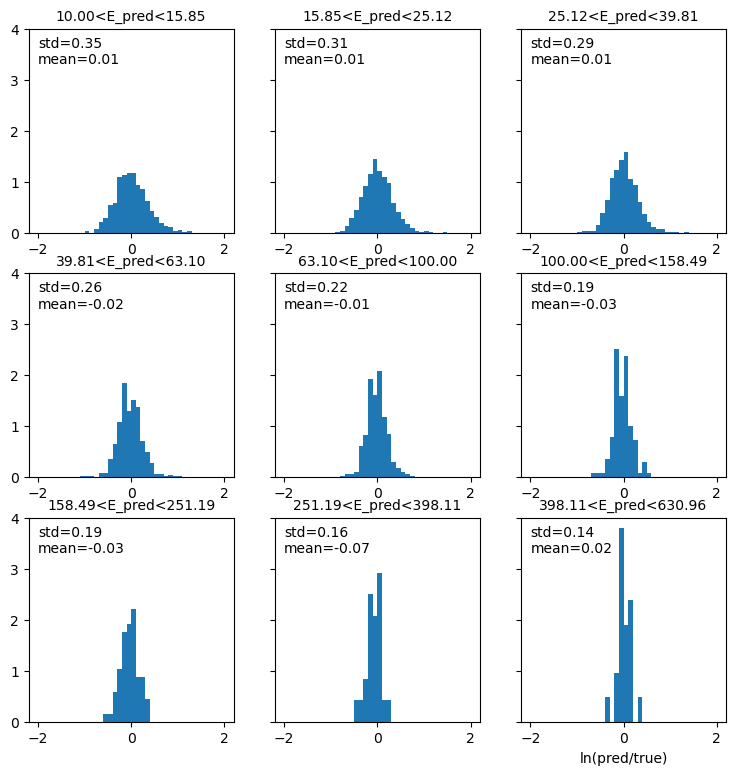

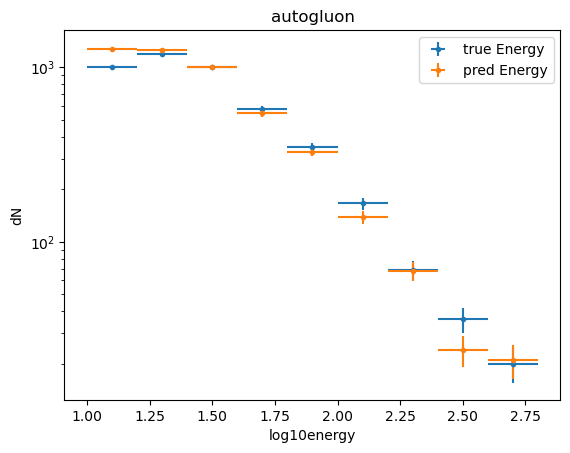

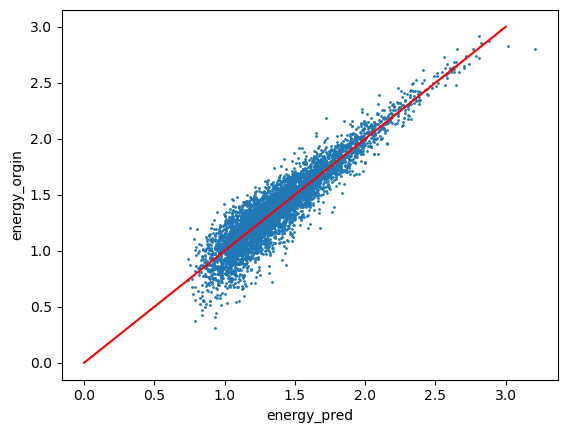

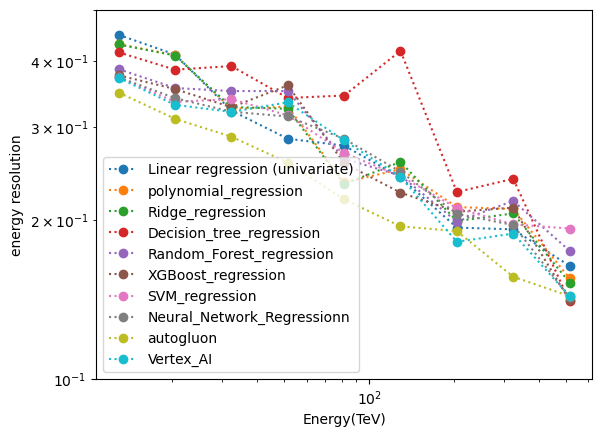

In [19]:
test_data_autogluon = TabularDataset("MC_test_Data.csv")
energy_pred = 10**predictor.predict(test_data_autogluon.drop(columns=["energy","log_energy"])).to_numpy()
energy_orgin = prie_test

check_fit(energy_pred, energy_orgin, method, tmpsavepath)

draw_precision()
np.save("precision.npy", precision)

Loaded data from: Expt_Data.csv | Columns = 10 / 10 | Rows = 20311659 -> 20311659
/home2/hky/miniconda3/envs/d2l/lib/python3.9/site-packages/catboost/core.py:1222: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/home2/hky/github/Gamma_Energy/energy_function.py:32: RuntimeWarning: divide by zero encountered in log
  Non * np.log((1 + alpha) / alpha * (Non / (Non + Noff)))
/home2/hky/github/Gamma_Energy/energy_function.py:32: RuntimeWarning: invalid value encountered in multiply
  Non * np.log((1 + alpha) / alpha * (Non / (Non + Noff)))


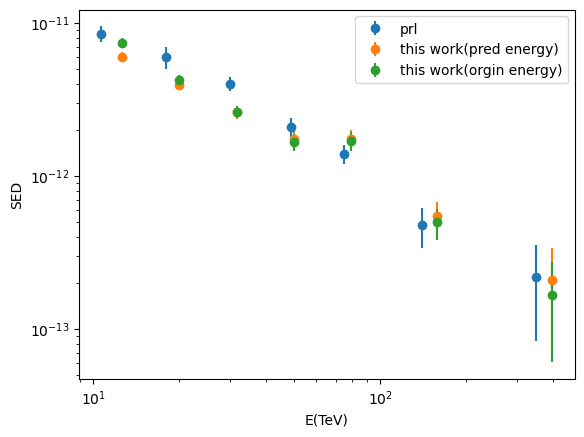

+--------------+--------------+--------+----------+--------+-------------+-----------------+--------------+------------------+
|   Energy min |   Energy max |     On |      Off |   Over |   rate_pred |   Spectrum_pred |   rate_orgin |   Spectrum_orgin |
+==============+==============+========+==========+========+=============+=================+==============+==================+
|         1.00 |         1.20 | 725.00 | 10991.41 | 175.43 |      0.0184 |      6.0186e-12 |       0.0149 |       7.4353e-12 |
+--------------+--------------+--------+----------+--------+-------------+-----------------+--------------+------------------+
|         1.20 |         1.40 | 448.00 |  5724.22 | 161.79 |      0.0408 |      3.9547e-12 |       0.0383 |       4.2145e-12 |
+--------------+--------------+--------+----------+--------+-------------+-----------------+--------------+------------------+
|         1.40 |         1.60 | 248.00 |  2602.76 | 117.86 |      0.0718 |      2.5980e-12 |       0.0713 |    

In [20]:
Expt_data_autogluon = TabularDataset("Expt_Data.csv")
ExptEnergy = 10**predictor.predict(Expt_data_autogluon).to_numpy()

GetSpectrum(Exptdata, ExptEnergy, energy_pred, energy_orgin, sectheta_test, sumpf_test,
            theta_test, phi_test, pritheta_test, priphi_test, test_size, tmpsavepath)


# Vertex AI

In [ ]:
method = "Vertex_AI"
tmpsavepath = os.path.join(savepath, method)
mkdir(tmpsavepath)

In [ ]:
AI_pre = pd.read_csv("/home2/hky/github/Gamma_Energy/prediction-MC_Energy-2023_03_16T19_25_55_531Z/prediction.results-00000-of-00021.csv")

In [ ]:
AI_pre = list()
AI_input = list()
for root, dirs, files in os.walk("/home2/hky/github/Gamma_Energy/prediction-MC_Energy-2023_03_16T19_25_55_531Z", topdown=False):
   for name in files:
      # print(os.path.join(root, name))
      AI_pre.append(pd.read_csv(os.path.join(root, name))["predicted_log_energy"].to_numpy())
      AI_input.append(pd.read_csv(os.path.join(root, name))["log_energy"].to_numpy())


In [ ]:
AI_pre = np.concatenate(AI_pre)
AI_input = np.concatenate(AI_input)

In [ ]:
check_fit(10**AI_pre, 10**AI_input, method, tmpsavepath)

draw_precision()
np.save("precision.npy", precision)

In [ ]:
draw_precision()
